In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/df_model_features.csv")
df.head()

,Ticket ID,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,desc_word_count,desc_char_count,subject_word_count
0,3,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,NaN,NaN,3.0,42,275,2
1,4,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,NaN,NaN,3.0,41,262,2
2,5,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,NaN,NaN,1.0,55,333,2
3,11,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,High,Phone,NaN,NaN,1.0,38,268,2
4,12,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,High,Chat,NaN,NaN,1.0,50,296,2


In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaylageorge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaylageorge/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kaylageorge/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
df["clean_text"] = df["Ticket Description"].apply(clean_text)
df[["Ticket Description", "clean_text"]].head()

,Ticket Description,clean_text
0,I'm facing a problem with my {product_purchase...,im facing problem productpurchased productpurc...
1,I'm having an issue with the {product_purchase...,im issue productpurchased please assist proble...
2,I'm having an issue with the {product_purchase...,im issue productpurchased please assist note s...
3,I'm having an issue with the {product_purchase...,im issue productpurchased please assist produc...
4,I'm having an issue with the {product_purchase...,im issue productpurchased please assist possib...


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_topics = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2),
    min_df=5,
    stop_words="english"
)

X_topics = tfidf_topics.fit_transform(df["clean_text"])
X_topics.shape

(2769, 1322)

In [5]:
from sklearn.decomposition import NMF 

n_topics = 6 

nmf = NMF(
    n_components=n_topics, 
    random_state=42,
    init='nndsvda'
)

W = nmf.fit_transform(X_topics) #document-topic matrix
H = nmf.components_ #topic-term matrix

/opt/anaconda3/envs/yolo503/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [6]:
import numpy as np 

feature_names = tfidf_topics.get_feature_names_out()

def print_top_words_per_topic(H, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(H):
        top_indices = np.argsort(topic)[-n_top_words:][::-1]
        top_terms = [feature_names[i] for i in top_indices]
        print(f"Topic {topic_idx + 1}:")
        print(", ".join(top_terms))
        print("-" * 60)

print_top_words_per_topic(H, feature_names, n_top_words=10)
                                

Topic 1:
unable option, guide step, desired action, productpurchased guide, perform desired, option perform, action productpurchased, desired, action, guide
------------------------------------------------------------
Topic 2:
errormessage mean, noticed peculiar, peculiar error, popping, popping productpurchased, errormessage, peculiar, say errormessage, message popping, screen say
------------------------------------------------------------
Topic 3:
update, started, software update, software, change device, recent, occurring, started occurring, update havent, problem started
------------------------------------------------------------
Topic 4:
work, fine time, intermittent, time act, act, unexpectedly, act unexpectedly, intermittent work, facing intermittent, work fine
------------------------------------------------------------
Topic 5:
issue, productpurchased, im, ive, persists, issue persists, assist, im issue, productpurchased assist, issue productpurchased
-----------------------

Interpretations: 

Topic 1: Customers can't figure out how to perform the action they want -- these are "please guide me / how do I do X?" tickets.

Topic 2: Tickets contain explicit error messages or unusual pop-ups -- users see warnings or alerts and need help troubleshooting

Topic 3: Issues begin after a recent update -- customers believe new firmware/software caused the malfunction

Topic 4: These tickets describe problems that happen sometimes -- devices behave inconsistently or randomly

Topic 5: Generic "I have an issue with my product, please help" tickets -- broad and non-specific

Topic 6: Customers already attempted resets or troubleshooting but still need help -- often escalation-ready

In [10]:
# Each row in W shows how strongly each ticket loads on each topic.
# We pick the topic with the highest score for each ticket.
df["dominant_topic"] = W.argmax(axis=1) + 1   # +1 makes topics 1–6 instead of 0–5
df[["clean_text", "dominant_topic"]].head()

,clean_text,dominant_topic
0,im facing problem productpurchased productpurc...,4
1,im issue productpurchased please assist proble...,5
2,im issue productpurchased please assist note s...,2
3,im issue productpurchased please assist produc...,5
4,im issue productpurchased please assist possib...,6


In [11]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

df["sentiment"] = df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kaylageorge/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


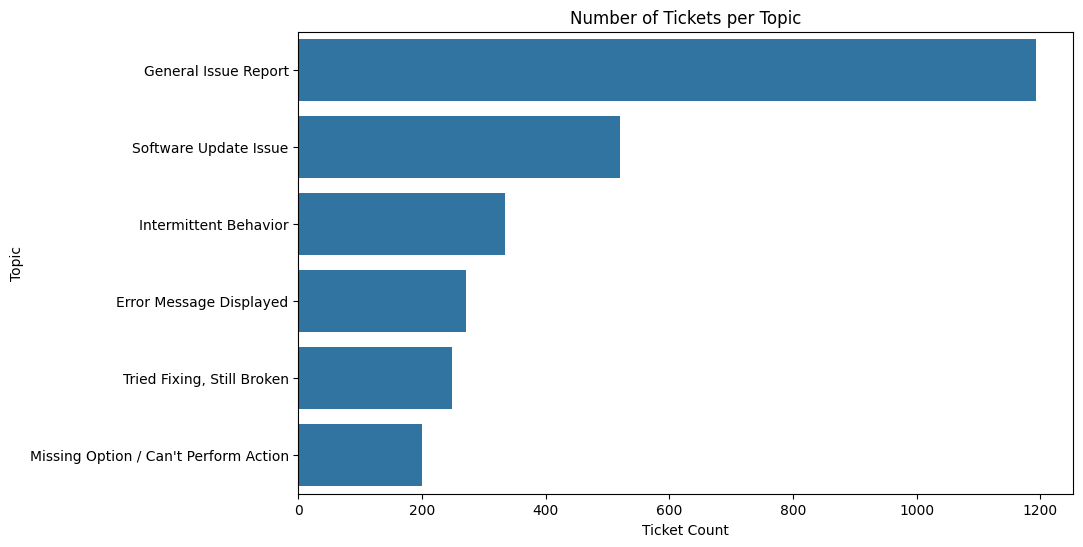

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

topic_labels = {
    1: "Missing Option / Can't Perform Action",
    2: "Error Message Displayed",
    3: "Software Update Issue",
    4: "Intermittent Behavior",
    5: "General Issue Report",
    6: "Tried Fixing, Still Broken"
}

df["topic_label"] = df["dominant_topic"].map(topic_labels)

plt.figure(figsize=(10, 6))
sns.countplot(y="topic_label", data=df, order=df["topic_label"].value_counts().index)
plt.title("Number of Tickets per Topic")
plt.xlabel("Ticket Count")
plt.ylabel("Topic")
plt.show(

/var/folders/fx/vhctjpgd6qjgbcltnf0nql_r0000gn/T/ipykernel_94490/3521327701.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


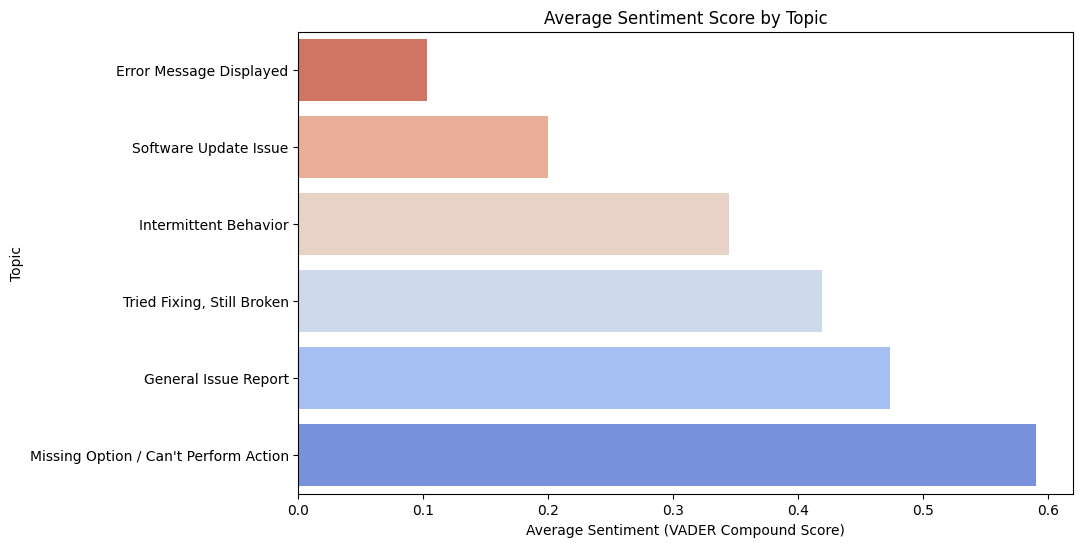

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(
    y="topic_label",
    x="sentiment",
    data=df,
    order=df.groupby("topic_label")["sentiment"].mean().sort_values().index,
    palette="coolwarm_r",   # ← reverse the palette
    errorbar=None
)
plt.title("Average Sentiment Score by Topic")
plt.xlabel("Average Sentiment (VADER Compound Score)")
plt.ylabel("Topic")
plt.show()

In [20]:
n_top_words = 8  # how many keywords you want per topic

topic_terms = {}

for topic_idx, topic in enumerate(H):
    top_indices = np.argsort(topic)[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    topic_terms[topic_labels[topic_idx+1]] = top_words

terms_df = pd.DataFrame(topic_terms)
terms_df

,Missing Option / Can't Perform Action,Error Message Displayed,Software Update Issue,Intermittent Behavior,General Issue Report,"Tried Fixing, Still Broken"
0,unable option,errormessage mean,update,work,issue,resolve problem
1,guide step,noticed peculiar,started,fine time,productpurchased,didnt
2,desired action,peculiar error,software update,intermittent,im,hoping
3,productpurchased guide,popping,software,time act,ive,productpurchased hoping
4,perform desired,popping productpurchased,change device,act,persists,hoping resolve
5,option perform,errormessage,recent,unexpectedly,issue persists,didnt help
6,action productpurchased,peculiar,occurring,act unexpectedly,assist,reset productpurchased
7,desired,say errormessage,started occurring,intermittent work,im issue,performed


In [21]:
clean_topics = {
    "Missing Option / Can't Perform Action": [
        "unable", "option", "guide", "step", "desired action", "perform", "missing option"
    ],
    "Error Message Displayed": [
        "error message", "popping", "screen", "peculiar", "noticed", "appears"
    ],
    "Software Update Issue": [
        "update", "software", "recent", "started", "occurring", "after update"
    ],
    "Intermittent Behavior": [
        "intermittent", "unexpected", "sometimes", "time", "act", "inconsistent"
    ],
    "General Issue Report": [
        "issue persists", "assist", "need help", "problem", "persisting"
    ],
    "Tried Fixing, Still Broken": [
        "reset", "resolve", "did not help", "performed", "attempted", "factory reset"
    ],
}

pd.DataFrame(dict([(k,pd.Series(v)) for k,v in clean_topics.items()]))

,Missing Option / Can't Perform Action,Error Message Displayed,Software Update Issue,Intermittent Behavior,General Issue Report,"Tried Fixing, Still Broken"
0,unable,error message,update,intermittent,issue persists,reset
1,option,popping,software,unexpected,assist,resolve
2,guide,screen,recent,sometimes,need help,did not help
3,step,peculiar,started,time,problem,performed
4,desired action,noticed,occurring,act,persisting,attempted
5,perform,appears,after update,inconsistent,NaN,factory reset
6,missing option,NaN,NaN,NaN,NaN,NaN


/var/folders/fx/vhctjpgd6qjgbcltnf0nql_r0000gn/T/ipykernel_94490/458305883.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


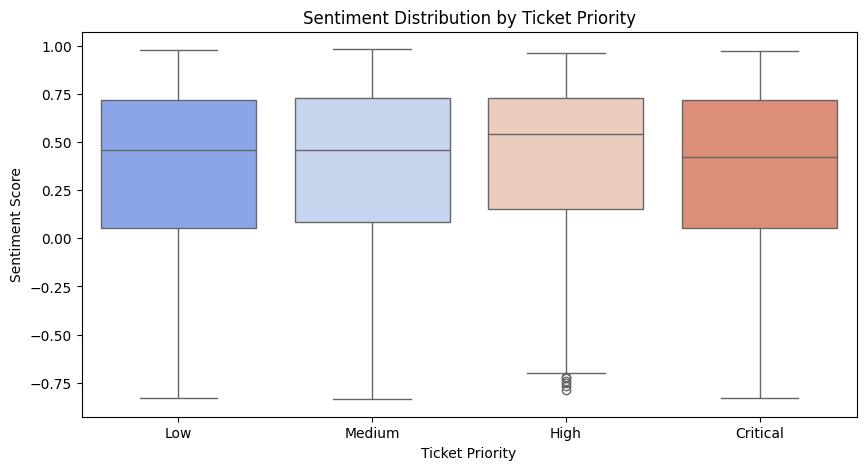

In [25]:
priority_order = ["Low", "Medium", "High", "Critical"]

plt.figure(figsize=(10, 5))
sns.boxplot(
    x="Ticket Priority",
    y="sentiment",
    data=df,
    order=priority_order,
    palette="coolwarm"
)
plt.title("Sentiment Distribution by Ticket Priority")
plt.xlabel("Ticket Priority")
plt.ylabel("Sentiment Score")
plt.show()

/var/folders/fx/vhctjpgd6qjgbcltnf0nql_r0000gn/T/ipykernel_94490/2225028746.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


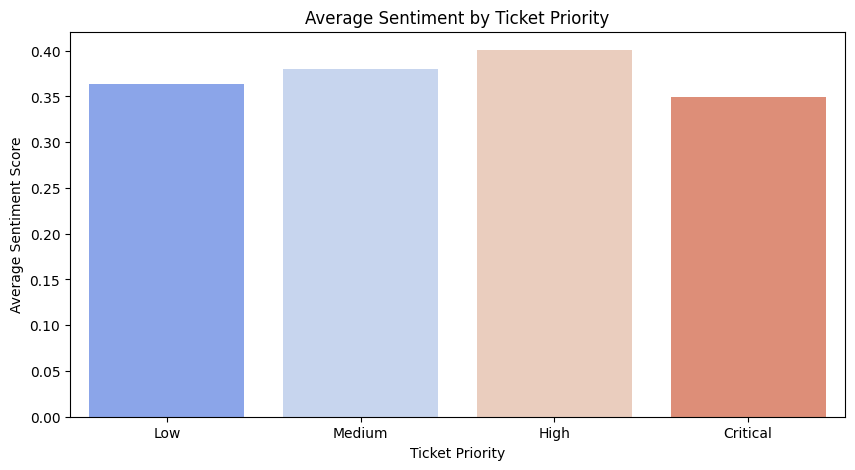

In [26]:
priority_order = ["Low", "Medium", "High", "Critical"]

plt.figure(figsize=(10, 5))
sns.barplot(
    x="Ticket Priority",
    y="sentiment",
    data=df,
    order=priority_order,
    estimator="mean",
    errorbar=None,
    palette="coolwarm"
)
plt.title("Average Sentiment by Ticket Priority")
plt.xlabel("Ticket Priority")
plt.ylabel("Average Sentiment Score")
plt.show()

Higher-priority tickets don’t necessarily have the most negative sentiment — users tend to stay neutral across categories, with only a slight dip for Critical issues.
                                                                                                                                                

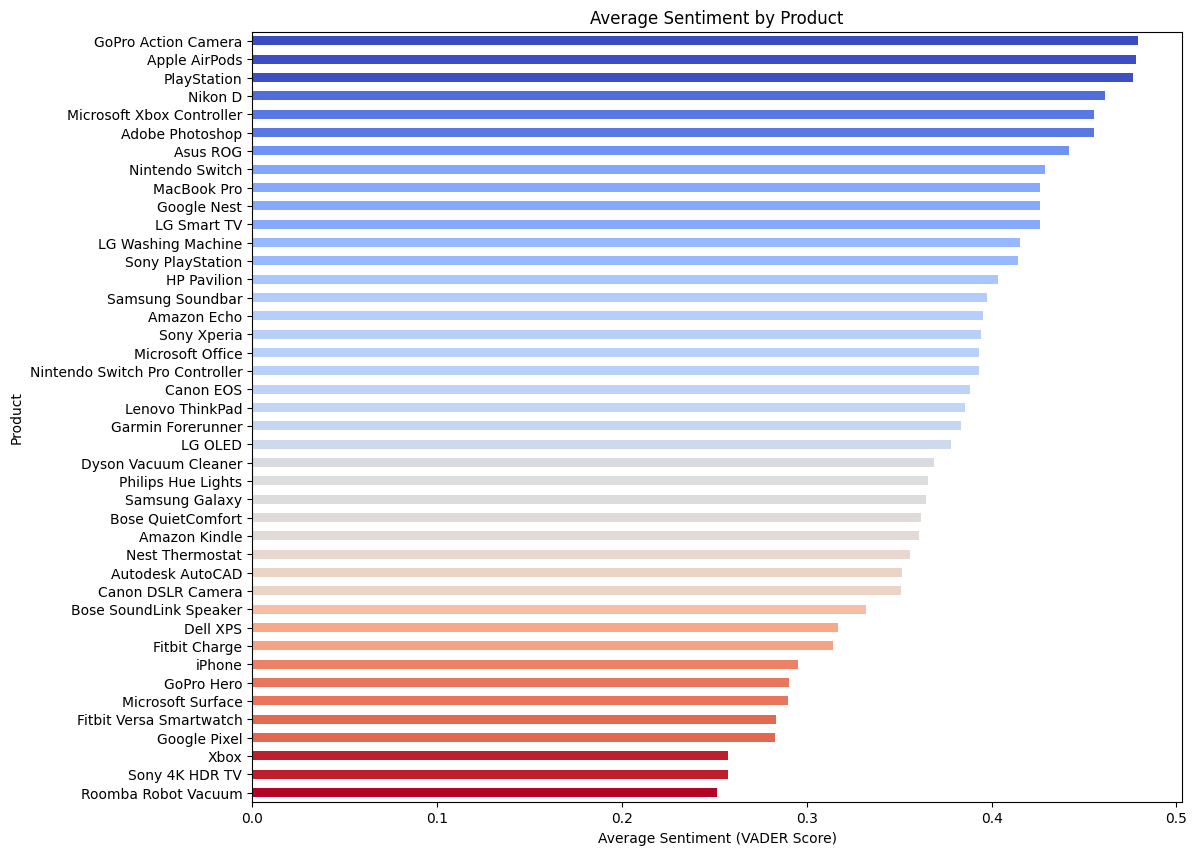

In [27]:
avg_sentiment_by_product = (
    df.groupby("Product Purchased")["sentiment"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(12, 10))
avg_sentiment_by_product.plot(
    kind="barh",
    color=plt.cm.coolwarm_r(
        (avg_sentiment_by_product - avg_sentiment_by_product.min()) /
        (avg_sentiment_by_product.max() - avg_sentiment_by_product.min())
    )
)
plt.title("Average Sentiment by Product")
plt.xlabel("Average Sentiment (VADER Score)")
plt.ylabel("Product")
plt.show()

### Average Sentiment by Product

Sentiment varies noticeably across product categories. Products at the top of the chart,
such as **GoPro Action Camera**, **AirPods**, **PlayStation**, **Nikon cameras**, and several
gaming or creative software tools, show the highest sentiment scores. This suggests that most
tickets for these products involve neutral inquiries or mild usability questions rather than
negative experiences.

Products at the bottom of the chart—such as **Roomba Robot Vacuum**, **Sony 4K HDR TV**, **Xbox**,
**Google Pixel**, and **Fitbit Versa Smartwatch**—tend to receive lower sentiment scores. Although
the dataset is synthetic and sentiment overall remains fairly positive, this relative ranking
highlights product categories that generate more frustration or troubleshooting attempts from users.

This view can help support teams prioritize workflows, documentation, and proactive guidance for
specific products where customers may be experiencing more negative interactions.